# Comparison of NICA algorithms

### Setup

In [1]:
import numpy as np
import scipy.linalg
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import math
import time
import glob
import os.path
import imageio
from quadprog import solve_qp

In [2]:
inv = np.linalg.inv
sqrtm = scipy.linalg.sqrtm
norm = np.linalg.norm

### Parameters

In [3]:
s_dim = 3 # source dimension
x_dim = 3 # mixed stimuli dimension, must satisfy x_dim >= s_dim
y_dim = s_dim # output dimension is the same as the source dimension
image_data = 'false'

In [4]:
trials = 1; epochs = 1

# Data generation

### Random mixing matrix

In [5]:
# A = np.random.randn(x_dim,s_dim) # random mixing matrix

# np.save(f"{s_dim}-dim-source/mixing-matrix.npy", A)

### Synthetic data

In [6]:
# samples = 10**5 # number of samples

# U = np.random.uniform(0,math.sqrt(48/5),(s_dim,samples)) # independent non-negative uniform source RVs with variance 1
# B = np.random.binomial(1, .5, (s_dim,samples)) # binomial RVs to sparsify the source
# S = U*B # sources
# X = A@S # mixtures

# filename = f"{s_dim}-dim-source/sources.npy"
# np.save(filename, S)
# filename = f"{s_dim}-dim-source/mixtures.npy"
# np.save(filename, X)

### Image data

Sources

In [7]:
# image_numbers = [5, 6, 11]; winsize=252 # 3 image patches are pre-specified
# posx = [220, 250, 200]
# posy = [1, 1, 1]

# S = np.zeros((s_dim, winsize**2))

# plt.figure(figsize=(15,10))

# for i in range(s_dim):
#     image = imageio.imread(f"data/images/{image_numbers[i]}.tiff")
#     window = image[posy[i]:posy[i] + winsize, posx[i]:posx[i] + winsize]
#     plt.subplot(s_dim, 1, i+1)
#     plt.imshow(window, cmap="gray")
#     np.save(f"data/images/source_{i}.npy", window)
#     window = window.reshape(1,-1)
#     window = window - window.min(axis=1)
#     window_var = np.cov(window)
#     window = window*(window_var**-.5)
#     S[i,:] = window

# plt.show
    
# S = np.array(S)

# filename = "data/images/sources.npy"
# np.save(filename, S)

Mixtures

In [8]:
# A = np.load(f"data/images/mixing-matrix.npy")

# X = A@S

# plt.figure(figsize=(15,10))

# for i in range(x_dim):
#     mixed = X[i].reshape(252,252)
#     plt.subplot(1, x_dim, i+1)
#     plt.imshow(mixed, cmap="gray")
#     np.save(f"data/images/mixture_{i}.npy", X[i])

# plt.show()

# filename = "data/images/mixtures.npy"
# np.save(filename, X)

# Load data

In [9]:
if image_data=='true':
    A = np.load(f"data/images/mixing-matrix.npy")
    S = np.load(f"data/images/sources.npy")
    X = np.load(f"data/images/mixtures.npy")
else:
    A = np.load(f"data/{s_dim}-dim-source/mixing-matrix.npy")
    S = np.load(f"data/{s_dim}-dim-source/sources.npy")
    X = np.load(f"data/{s_dim}-dim-source/mixtures.npy")

In [10]:
samples = S.shape[1]; iters = epochs*samples

# Bio-NICA

### Parameters

In [11]:
a = 10; b = .1; tau = .8 # optimal parameters for 3-dimensional synthetic data
# a = 1000; b = .1; tau = .03 # optimal parameters for 10-dimensional synthetic data 
# a = 1000; b = .001; tau = .05 # optimal parameters for image data

### Online algorithm

Trial 1:
Epoch 1:
run time: 9.466198921203613 seconds


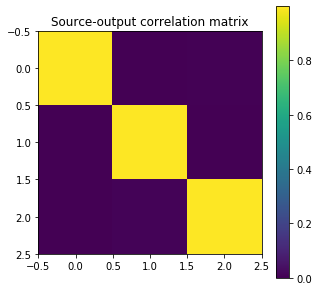

In [12]:
error = np.zeros((trials,iters))
runtime = np.zeros((trials,iters))

S_permuted = np.zeros((trials,s_dim,iters)) # matrix for keeping track of the order the sources were presented across trials
Y = np.zeros((trials,y_dim,iters)) # matrix for keeping track of the outputs across trials

for n in range(trials):

    print('Trial {}:'.format(n+1))

    # initialize a random matrix W whose rows have norm 1:

    W = np.random.randn(y_dim,x_dim)
    for i in range(y_dim):
        W[i,:] = W[i,:]/norm(W[i,:])

    # initialize M to be the identity matrix, choosing M to be a random postive definite matrix can lead to problems with degeneracy:

    M = np.eye(y_dim)

    # inialize running means:

    x_bar = 0
    c_bar = 0

    start_time = time.time()

    for m in range(epochs):

        print('Epoch {}:'.format(m+1))

        S_recovered = np.zeros((y_dim,samples)) # matrix for keeping track of outputs over the current epoch

        idx = np.random.permutation(samples) # random permutation of the samples

        for k in range(samples):

            # compute iteration number:

            t = m*samples + k

            # compute step size:

            eta_t = 1/(a+b*t)

            # input

            i = idx[k]

            S_permuted[n,:,t] = S[:,i]

            x = X[:,i]
            x_bar = x_bar + (x - x_bar)/(t+1) # running average of x 
            x_hat = x - x_bar # centered x

            c = W@x
            c_bar = c_bar + (c - c_bar)/100 # running weighted average of c
            c_hat = c - c_bar # centered c

            # neural dynamics

            y = solve_qp(M, c, np.eye(y_dim), np.zeros(y_dim))[0]
            Y[n,:,t] = y; S_recovered[:,i] = y

            # synaptic updates

            W = W + 2*eta_t*(np.outer(y,x) - np.outer(c_hat,x_hat))
            M = M + (eta_t/tau)*(np.outer(y,y) - M)
            
            # the matrix M can sometimes exhibit instaiblities due to noise, which can be addressed with the following ad hoc fix (the alternative is to reduce the learning rate):
            
            if scipy.linalg.det(M)<.001:
                M = M + .1*np.eye(y_dim)
                print('M close to degenerate')

            # check to see if any neurons (i.e. components of y) are not firing after the first 10 samples

            if t==10:
                for j in range(y_dim):
                    if sum(Y[n,0:t,j])==0:
                        W[j,:] = -W[j,:]
                        print('flip',j)

            runtime[n,t] = time.time() - start_time

        # output

        print('run time: %s seconds' % runtime[n,t])

        # correlations between the outputs and sources; if the algorithm is performing well, this matrix should be close to a permutation matrix

        corr = np.corrcoef(S,S_recovered)[:s_dim,s_dim:]

        fig=plt.figure(figsize=(5,5))

        plt.imshow(corr)
        plt.title('Source-output correlation matrix')
        plt.colorbar()
        plt.show()

    # compute the optimal permutation matrix

    perm = np.round(np.corrcoef(S,S_recovered))[:s_dim,s_dim:] # if the algorithm performs well, rounding the correlation matrix yields the optimal permutation matrix

    # compute error

    for t in range(1,iters):

        error_t = (norm(S_permuted[n,:,t] - perm@Y[n,:,t])**2)/s_dim
        error[n,t] = error[n,t-1] + (error_t - error[n,t-1])/t

# save data

if image_data=='true':
    np.save(f"data/images_bio-nica_error.npy", error)
    np.save(f"data/images_bio-nica_runtime.npy", runtime)
else:
    np.save(f"data/{s_dim}-dim-source_bio-nica_error.npy", error)
    np.save(f"data/{s_dim}-dim-source_bio-nica_runtime.npy", runtime)

# 2-layer NSM

### Parameters

In [13]:
a = 100; b = .001 # optimal parameters for 3-dimensional synthetic data
# a = 100; b = .001 # optimal parameters for 10-dimensional synthetic data 
# a = 100; b = .01 # optimal parameters for image data

### Online algorithm

Trial 1:
Epoch 1:
run time: 9.400677680969238 seconds


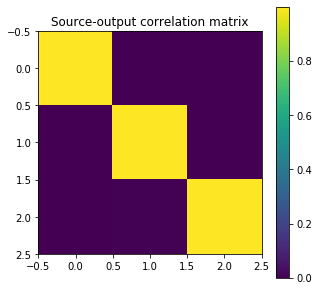

In [14]:
error = np.zeros((trials,iters))
runtime = np.zeros((trials,iters))

S_permuted = np.zeros((trials,s_dim,iters))
Y = np.zeros((trials,y_dim,iters))

h_dim = y_dim

for n in range(trials):

    print('Trial {}:'.format(n+1))

    Whx = np.random.randn(h_dim,x_dim)
    Wgh = np.eye(h_dim)
    Wyh = np.random.randn(y_dim,h_dim)
    Wyy = np.eye(y_dim)

    for i in range(h_dim):
        Whx[i,:] = Whx[i,:]/norm(Whx[i,:])
        Wyh[i,:] = Wyh[i,:]/norm(Wyh[i,:])

    x_bar = 0
    h_bar = 0
    g_bar = 0

    start_time = time.time()

    for m in range(epochs):

        print('Epoch {}:'.format(m+1))

        S_recovered = np.zeros((y_dim,samples))

        idx = np.random.permutation(samples) # random permutation of the samples

        for k in range(samples):

            t = m*samples + k

            eta_t = 1/(100+t)
            gamma_t = 1/(a+b*t)

            # input

            i = idx[k]

            S_permuted[n,:,t] = S[:,i]

            x = X[:,i]
            x_bar = x_bar + (x - x_bar)/(t+1)
            x_hat = x - x_bar

            # neural dynamics

            h = inv(Wgh.T@Wgh)@Whx@x
            h_bar = h_bar + (h - h_bar)/(t+1)
            h_hat = h - h_bar

            g = Wgh@h
            g_bar = g_bar + (g - g_bar)/(t+1)
            g_hat = g - g_bar

            c = Wyh@h
            y = solve_qp(Wyy, c, np.eye(y_dim), np.zeros(y_dim))[0]
            Y[n,:,t] = y; S_recovered[:,i] = y

            # synaptic updates

            Whx = Whx + eta_t*(np.outer(h_hat,x_hat) - Whx)
            Wgh = Wgh + eta_t*(np.outer(g_hat,h_hat) - Wgh)
            Wyh = Wyh + gamma_t*(np.outer(y,h) - Wyh)
            Wyy = Wyy + gamma_t*(np.outer(y,y) - Wyy)

            # check to see if any neurons (i.e. components of y) are not firing

            if t==10:        
                for j in range(y_dim):
                    if sum(Y[n,0:t,j])==0:
                        Wyh[j,:] = -Wyh[j,:]

            runtime[n,t] = time.time() - start_time

        # output

        print('run time: %s seconds' % runtime[n,t])

        # correlations between the outputs and sources; if the algorithm is performing well, this matrix should be close to a permutation matrix

        corr = np.corrcoef(S,S_recovered)[:s_dim,s_dim:]

        fig=plt.figure(figsize=(5,5))

        plt.imshow(corr)
        plt.title('Source-output correlation matrix')
        plt.colorbar()
        plt.show()

    perm = np.round(np.corrcoef(S,S_recovered)[:s_dim,s_dim:])

    for t in range(1,iters):

        error_t = (norm(S_permuted[n,:,t] - perm@Y[n,:,t])**2)/s_dim
        error[n,t] = error[n,t-1] + (error_t - error[n,t-1])/t

# save data

if image_data=='true':
    np.save(f"data/images_nsm_error.npy", error)
    np.save(f"data/images_nsm_runtime.npy", runtime)
else:
    np.save(f"data/{s_dim}-dim-source_nsm_error.npy", error)
    np.save(f"data/{s_dim}-dim-source_nsm_runtime.npy", runtime)

# Nonnegative PCA

### Parameters

In [15]:
a = 1000; b = .01 # optimal parameters for 3-dimensional synthetic data
# a = 1000; b = .01 # optimal parameters for 10-dimensional synthetic data 
# a = 1000; b = .01 # optimal parameters for image data

### Non-centered whitening

In [16]:
Cxx = np.cov(X)
H = inv(sqrtm(Cxx))@X # whitened mixtures
# R = inv(sqrtm(A@A.T))@A # whitening matrix
# H = R@S 

### Online algorithm

Trial 1:
Epoch 1:
flip 0
run time: 1.6990888118743896 seconds


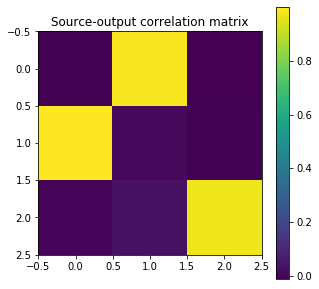

In [17]:
error = np.zeros((trials,iters))
runtime = np.zeros((trials,iters))

S_permuted = np.zeros((trials,s_dim,iters))
Y = np.zeros((trials,y_dim,iters))

for n in range(trials):

    print('Trial {}:'.format(n+1))

    W = np.random.randn(y_dim,x_dim)

    for i in range(y_dim):
        W[i,:] = W[i,:]/norm(W[i,:])

    start_time = time.time()

    for m in range(epochs):

        print('Epoch {}:'.format(m+1))

        S_recovered = np.zeros((y_dim,samples))

        idx = np.random.permutation(samples) # random permutation of the samples

        for k in range(samples):

            t = m*samples + k

            eta_t = 1/(a+b*t)

            i = idx[k]

            S_permuted[n,:,t] = S[:,i]

            # input

            h = H[:,i]

            y = np.maximum(W@h,0); Y[n,:,t] = y; S_recovered[:,i] = y

            # synaptic updates

            W = W + eta_t*(np.outer(y,h)-np.outer(y,y)@W)

            # check to see if any neurons (i.e. components of y) are not firing

            if t==10:        
                for j in range(y_dim):
                    if sum(Y[n,j,0:t])==0:
                        W[j,:] = -W[j,:]
                        print('flip',j)

            runtime[n,t] = time.time() - start_time

        # output

        print('run time: %s seconds' % runtime[n,t])

        # correlations between the outputs and sources; if the algorithm is performing well, this matrix should be close to a permutation matrix

        corr = np.corrcoef(S,S_recovered)[:s_dim,s_dim:]

        fig=plt.figure(figsize=(5,5))

        plt.imshow(corr)
        plt.title('Source-output correlation matrix')
        plt.colorbar()
        plt.show()

    perm = np.round(np.corrcoef(S,S_recovered)[:s_dim,s_dim:])

    for t in range(1,iters):

        error_t = (norm(S_permuted[n,:,t] - perm@Y[n,:,t])**2)/s_dim
        error[n,t] = error[n,t-1] + (error_t - error[n,t-1])/t

# save data

if image_data=='true':
    np.save(f"data/images_npca_error.npy", error)
    np.save(f"data/images_npca_runtime.npy", runtime)
else:
    np.save(f"data/{s_dim}-dim-source_npca_error.npy", error)
    np.save(f"data/{s_dim}-dim-source_npca_runtime.npy", runtime)

# fastICA

### Parameters

In [18]:
a = 10; b = .001 # optimal parameters for 3-dimensional synthetic data
# a = 1000; b = .01 # optimal parameters for 10-dimensional synthetic data 
# a = 100; b = .01 # optimal parameters for image data

alpha = .5

### Nonlinearity

In [19]:
def f(y):
    return np.tanh(y)

def f_prime(y):
    return (1 - np.tanh(y)**2)

### Whitening

In [20]:
Cxx = np.cov(X)
X_mean = np.mean(X,axis=1)
H_centered = inv(sqrtm(Cxx))@(X - np.outer(X_mean,np.ones(X.shape[1]).T))

# R = inv(sqrtm(A@A.T))@A # whitening matrix
# H = R@S # whitened mixtures
# H_mean = H.mean(axis=1)
# H_centered = H - np.outer(H_mean,np.ones(samples)) # whitened/centered mixtures

### Signal mean

In [21]:
S_mean = S.mean(axis=1)

### Online algorithm

Trial 1:
Epoch 1:
run time: 3.920363187789917 seconds


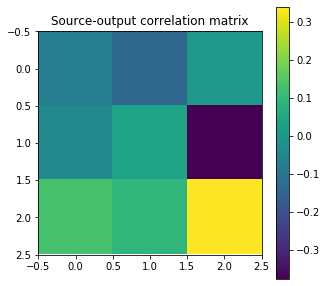

In [26]:
error = np.zeros((trials,iters))
runtime = np.zeros((trials,iters))

S_permuted = np.zeros((trials,s_dim,iters)) # matrix keeping track of the source presented in trial n, iteration t
Y = np.zeros((trials,y_dim,iters)) # matrix keeping track of output of trial n, iteration t

for n in range(trials):

    print('Trial {}:'.format(n+1))

    W = np.random.randn(y_dim,x_dim)

    for i in range(y_dim):
        W[i,:] = W[i,:]/norm(W[i,:])

    C = np.ones(y_dim)

    start_time = time.time()

    for m in range(epochs):

        print('Epoch {}:'.format(m+1))

        S_recovered = np.zeros((y_dim,samples))

        idx = np.random.permutation(samples) # random permutation of the samples

        for k in range(samples):

            t = m*samples + k

            eta_t = 1/(a+b*t)

            i = idx[k]

            S_permuted[n,:,t] = S[:,i] - S_mean # center the sources for comparison with the outputs

            # input

            h = H_centered[:,i]

            # neural dynamics

            y = W@h; Y[n,:,t] = y; S_recovered[:,i] = y

            for j in range(y_dim):
                C[j] = C[j] + .1*(y[j]*f(y[j]) - f_prime(y[j]) - C[j])

            sign_C = np.sign(C)
            diag_C = np.diag(sign_C)

#             W = W + eta_t*diag_C@np.outer(f(y),x) + alpha*(np.eye(y_dim) - W@(W.T))@W
            W = W + eta_t*np.outer(f(y),x) + alpha*(np.eye(y_dim) - W@(W.T))@W

            runtime[n,t] = time.time() - start_time

        # output

        print('run time: %s seconds' % runtime[n,t])

        # correlations between the outputs and sources; if the algorithm is performing well, this matrix should be close to a permutation matrix

        corr = np.corrcoef(S,S_recovered)[:s_dim,s_dim:]

        fig=plt.figure(figsize=(5,5))

        plt.imshow(corr)
        plt.title('Source-output correlation matrix')
        plt.colorbar()
        plt.show()

    perm = np.round(np.corrcoef(S,S_recovered)[:s_dim,s_dim:])

    for t in range(1,iters):

        error_t = (norm(S_permuted[n,:,t] - perm@Y[n,:,t])**2)/s_dim
        error[n,t] = error[n,t-1] + (error_t - error[n,t-1])/t

# save data

if image_data=='true':
    np.save(f"data/images_fica_error.npy", error)
    np.save(f"data/images_fica_runtime.npy", runtime)
else:
    np.save(f"data/{s_dim}-dim-source_fica_error.npy", error)
    np.save(f"data/{s_dim}-dim-source_fica_runtime.npy", runtime)

# Comparisons

### Function for plotting confidence intervals

In [27]:
def add_ci_line(axis, t, data, ci_pct=68, plot_kwargs=None, ci_kwargs=None):
    mu = data.mean(axis=0)
    delta = (100 - ci_pct) / 2
    ci_lo = np.percentile(data, delta, axis=0)
    ci_hi = np.percentile(data, 100 - delta, axis=0)
    assert mu.shape == ci_lo.shape == ci_hi.shape
    plot_kwargs = plot_kwargs or {}
    ci_kwargs = ci_kwargs or {}
    plot = axis.plot(t, mu, **plot_kwargs)
    fill = axis.fill_between(t, ci_lo, ci_hi, alpha=.05, **ci_kwargs)
    return plot, fill

### Parameters

In [28]:
s_dim = 3; image_data = 'false'

### Load data

In [29]:
if image_data=='true':
    bio_nica_error = np.load(f"data/images_bio-nica_error.npy")
    nsm_error = np.load(f"data/images_nsm_error.npy")
    npca_error = np.load(f"data/images_npca_error.npy")
    fica_error = np.load(f"data/images_fica_error.npy")
else:
    bio_nica_error = np.load(f"data/{s_dim}-dim-source_bio-nica_error.npy")
    nsm_error = np.load(f"data/{s_dim}-dim-source_nsm_error.npy")
    npca_error = np.load(f"data/{s_dim}-dim-source_npca_error.npy")
    fica_error = np.load(f"data/{s_dim}-dim-source_fica_error.npy")

### Sample efficiency

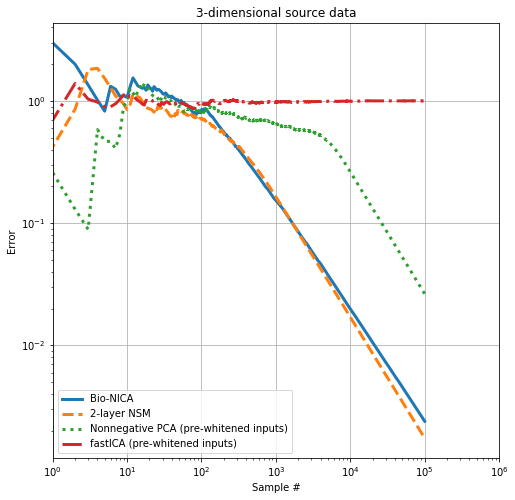

In [30]:
fig = plt.figure(figsize=(8,8))

linewidth = 3

t = list(range(iters))
ci = 90

ax = plt.subplot(1, 1, 1)
add_ci_line(
    ax,
    t,
    bio_nica_error,
    ci_pct = ci,
    plot_kwargs={"ls": "-", "lw": linewidth, "label": "Bio-NICA"},
)
add_ci_line(
    ax,
    t,
    nsm_error,
    ci_pct = ci,
    plot_kwargs={"ls": "--", "lw": linewidth, "label": "2-layer NSM"},
)
add_ci_line(
    ax,
    t,
    npca_error,
    ci_pct = ci,
    plot_kwargs={"ls": ":", "lw": linewidth, "label": "Nonnegative PCA (pre-whitened inputs)"},
)
add_ci_line(
    ax,
    t,
    fica_error,
    ci_pct = ci,
    plot_kwargs={"ls": "-.", "lw": linewidth, "label": "fastICA (pre-whitened inputs)"},
)
ax.loglog()

if image_data=='true':
    plt.title(f"Natural images source data")
else:
    plt.title(f"{s_dim}-dimensional source data")

plt.xlabel("Sample #")
plt.ylabel("Error")
plt.xlim((1,10**6))
plt.grid()
plt.legend(loc = "lower left")

if image_data=='true':
    plt.savefig(f"data/images-source_comparison.png", dpi=300, transparent='true', bbox_inches='tight')
else:
    plt.savefig(f"data/{s_dim}-dim-source_comparison.png", dpi=300, transparent='true', bbox_inches='tight')